## 추론(예측) 기반 기법과 신경망

## word2vec : 워드투벡터
2013년 구글의 토마스미콜로프(Tomas Mikolov)의 팀이 개발<br>
<b>word2vec</b> 알고리즘은 <b>신경망 모델</b>을 사용 하여 큰 텍스트 코퍼스에서 단어 연관성을 학습. 학습이 끝나면 이러한 모델은 동의어 단어를 감지하거나 부분 문장에 대한 추가 단어를 제안 할 수 있다. word2vec는 <b>벡터</b> 라고하는 특정 숫자 목록을 사용하여 각각의 고유 한 단어를 나타낸다 . 벡터는 간단한 수학적 함수 ( 벡터 간의 코사인 유사성 ) 가 해당 벡터가 나타내는 단어 간의 의미 유사성 수준을 나타내 도록 신중하게 선택 된다.

### [1] 신경망에서의 단어 처리

In [1]:
import numpy as np

text = 'You say goodbye and I say hello.' 
# {0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}

# 여기서 'you'만  one-hot 인코딩으로 표현
c = np.array([[1,0,0,0,0,0,0]])   # (1,7)
print('c:\n',c)

W = np.random.randn(7,3)          # (7,3)
print('W:\n',W)

h = np.matmul(c,W)    # (1,7) * (7,3) = (1,3)
print('h:\n',h)

c:
 [[1 0 0 0 0 0 0]]
W:
 [[-1.28538961  0.64792478 -0.37034692]
 [-1.32314326  0.22349505 -3.10678191]
 [ 1.0895167   1.81182082  0.22445226]
 [ 1.25819541 -1.11850756  0.48816333]
 [ 0.28208495 -1.10086583  0.08395836]
 [-0.42763555  1.3866479  -0.12573135]
 [-0.15107386 -0.55324631 -0.0185085 ]]
h:
 [[-1.28538961  0.64792478 -0.37034692]]


In [2]:
class MatMul:
    def __init__(self,W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.x = None
        
    def forward(self,x):
        W, = self.params
        out = np.dot(x,W)
        self.x = x
        return out
        
    def backward(self,dout):
        W = self.params
        dx = np.dot(dout,W.T)
        dw = np.dot(self.x.T,dout)
        self.grads[0][...] = dw  # 깊은복사
        return dx

In [3]:
text = 'You say goodbye and I say hello.' 
# {0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}

# 여기서 'you'만  one-hot 인코딩으로 표현
c = np.array([[1,0,0,0,0,0,0]])   # (1,7)
print('c:\n',c)

W = np.random.randn(7,3)          # (7,3)
print('W:\n',W)

layer = MatMul(W)
h = layer.forward(c)
print('h:\n',h)

c:
 [[1 0 0 0 0 0 0]]
W:
 [[-0.03242822  1.2190229   0.45928323]
 [-2.61749499  1.55165468  0.28560177]
 [ 0.74289918 -0.05973607  0.34769935]
 [-0.68861041  0.18058425 -0.28971501]
 [-1.04228678  0.93596162  0.10277779]
 [-0.43039547  0.50823827 -1.20898852]
 [-0.2251487   1.52103797 -0.52640616]]
h:
 [[-0.03242822  1.2190229   0.45928323]]


## [2] 단순한 word2vec

### CBOW (Continuous Bag of Words) 모델

#### Word2Vec에는 CBOW(Continuous Bag of Words)와 Skip-Gram 두 가지 방식이 있다
- $ CBOW $ 는 주변에 있는 단어들을 가지고, 중간에 있는 단어들을 예측하는 방법 <br>
  타깃(target)은 중앙 단어 그 주변 단어들이 맥락(contexts)이다
- $ Skip-Gram $ 은 중간에 있는 단어로 주변 단어들을 예측하는 방법

#### BOW(Bag of Words) : 단어들의 순서는 전혀 고려하지 않고, 단어들의 출현 빈도(frequency)에만 집중하는 텍스트 데이터의 수치화 표현 방법

BOW를 만드는 과정<br>
(1) 우선, 각 단어의 고유한 인덱스(Index)를 부여한다.<br>
(2) 각 인덱스의 위치에 단어 토큰의 등장 횟수를 기록한 벡터(Vector)를 만든다.<br>

"정부가 발표하는 물가상승률과 소비자가 느끼는 물가상승률은 다르다."<br>
('정부': 0, '가': 1, '발표': 2, '하는': 3, '물가상승률': 4, '과': 5, '소비자': 6, '느끼는': 7, '은': 8, '다르다': 9) <br>
BOW: [1, 2, 1, 1, 2, 1, 1, 1, 1, 1]  ==> '가' 와 '물가상승률' 은 2회 발생

In [4]:
# (CBOW 전체구조의 Preview)
# 샘플 맥락 데이터 : 2개의 주변 단어를 맥락으로 중간 단어('say')를 예측

text = 'You say goodbye and I say hello.' 

# 2개의 주변 단어를 one-hot 벡터 생성
c0 = np.array([[1,0,0,0,0,0,0]])  # 'you' , (1,7)
c1 = np.array([[0,0,1,0,0,0,0]])  # 'goodbye' , (1,7)

# 가중치 초기화
W_in = np.random.randn(7,3)
W_out = np.random.randn(3,7)

# 계층 생성
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

# 순전파
h0 = in_layer0.forward(c0) # (1,7) * (7,3) = (1,3)
h1 = in_layer1.forward(c1) # (1,7) * (7,3) = (1,3)
h = 0.5*(h0 + h1)
print(h,h.shape)
s = out_layer.forward(h)   # (1,3) * (3,7) = (1,7)
print(s,s.shape)            

[[1.07329764 0.54778421 0.69472239]] (1, 3)
[[ 1.39817177  0.2844833  -0.64249062  0.76180552  0.51063952  1.21341815
   1.32639781]] (1, 7)


## [3] 학습 데이터 준비

In [5]:
from mynlp import preprocess
import matplotlib.pyplot as plt

In [6]:
text = 'You say goodbye and I say hello.' 
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)      # 8 개
print(id_to_word)  # 7 개

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [7]:
# target : (6,)
target = corpus[1:-1]  # 타깃(중간단어) : [1 2 3 4 1 5], 첫번째와 마지막 단어 제외
print('target:',target)

contexts = []
for idx in range(1,len(corpus) - 1 ): # 1 to 6,6회 반복 , 중간단어마다 앞뒤 주변단어 조합 6가지
    cs = []
    for t in range(-1,2): # 3회, -1,0,1
        if t == 0:
            continue
        cs.append(corpus[idx + t]) 
    contexts.append(cs)  

print('contexts:\n',np.array(contexts))   

target: [1 2 3 4 1 5]
contexts:
 [[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]


In [8]:
# contexts와 target을 구하는 함수
def create_contexts_target(corpus,window_size=1):
    target = corpus[window_size:-window_size]  

    contexts = []
    for idx in(range(window_size,len(corpus) -window_size)): 
        cs = []
        for t in range(-window_size,window_size+1) : 
            if t == 0: 
                continue
            cs.append(corpus[idx + t]) 
        contexts.append(cs)
    return np.array(contexts),np.array(target) 

In [9]:
contexts,target = create_contexts_target(corpus,window_size=1)
print(contexts)  # (6,2)

# 맥락(contexts) : 예측할 단어의 주변 단어
# {0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}
# window_size=1 일 경우 : 주변 단어를 중간 단어에 앞,뒤로 1개만 사용
# [[0 2]   : 'you', 'goodbye'
#  [1 3]   : 'say', 'and'
#  [2 4]   : 'goodbye', 'i'
#  [3 1]   : 'and', 'say'
#  [4 5]   : 'i', 'hello'
#  [1 6]]  : 'say', '.'

# window_size=2 일 경우 : : 주변 단어를 중간 단어에 앞,뒤로 2개 사용
# [[0 1 3 4]
#  [1 2 4 1]
#  [2 3 1 5]
#  [3 4 5 6]]

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]


In [10]:
print(target)   # (6,)
# 타깃(target) : 예측할 단어, 중간단어, 6개
# ['say','goodbye','and','i','say','hello']
# [1 2 3 4 1 5]

[1 2 3 4 1 5]


### 맥락과 타깃을 원핫 표현으로 변환

In [11]:
# 원핫 변환 함수

# target [1 2 3 4 1 5]을 변환하는 경우를 주석으로 설명 
def convert_one_hot(corpus, vocab_size):  # [1 2 3 4 1 5], 7
    N = corpus.shape[0] # (6,) --> 6

    if corpus.ndim == 1: # target [1 2 3 4 1 5], 1차원인경우 ==> 2차원으로 출력
        one_hot = np.zeros((N, vocab_size), dtype=np.int32) # 0으로 초기화된 (6,7) 2차원 배열 생성 
        for idx, word_id in enumerate(corpus): # 6회 반복
            one_hot[idx, word_id] = 1  # one_hot[0,1] = 1, [1,2]=1, [2,3] = 1,...,  [3,4],[4,1],[5,5] = 1...

    elif corpus.ndim == 2: # contexts 2차원 인경우 ==> 3차원으로 출력
        C = corpus.shape[1] # (6,2) --> 2
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32) # 0으로 초기화된 (6,2,7) 3차원 배열 생성 
        for idx_0, word_ids in enumerate(corpus): # 6회
            for idx_1, word_id in enumerate(word_ids): #  2회
                one_hot[idx_0, idx_1, word_id] = 1  

    return one_hot

In [12]:
vocab_size = len(word_to_id)
print(vocab_size) # 7

target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

7


In [13]:
print(target)
print(target.shape)  # (6, 7)
# [1 2 3 4 1 5]

[[0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
(6, 7)


In [14]:
print(contexts.shape) # (6, 2, 7)
print(contexts)
# [[0 2]
#  [1 3]
#  [2 4]
#  [3 1]
#  [4 5]
#  [1 6]]

(6, 2, 7)
[[[1 0 0 0 0 0 0]
  [0 0 1 0 0 0 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 1 0 0 0]]

 [[0 0 1 0 0 0 0]
  [0 0 0 0 1 0 0]]

 [[0 0 0 1 0 0 0]
  [0 1 0 0 0 0 0]]

 [[0 0 0 0 1 0 0]
  [0 0 0 0 0 1 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 0 0 0 1]]]


## [4] CBOW 신경망 모델 구현

In [15]:
from nn_layers import MatMul, SoftmaxWithLoss, SGD, Adam

In [16]:
# 다중 분류 모델 : Softmax 사용
class SimpleCBOW :
    def __init__(self, vocab_size, hidden_size): # 단어의 갯수: 7, 은닉층의 뉴런: 5
        V,H = vocab_size, hidden_size
        
        # 가중치 초기화
        W_in = 0.01*np.random.randn(V,H).astype('f') # (7,5)
        W_out = 0.01*np.random.randn(H,V).astype('f') # (5,7)
        
        # 계층 생성
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()
        
        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [],[]
        for layer in layers : # 3회
            self.params += layer.params
            self.grads += layer.grads
            
        # 인스턴스 변수 단어의 분산 표현을 저장한다.    
        self.word_vec = W_in    
        
    def predict(self,contexts):  # contexts :  (6, 2, 7)
        
        # (6,7) * (7,5)  =  (6,5)
        h0 = self.in_layer0.forward(contexts[:,0]) #  (6,7)으로 입력, 맥락의 첫번째 단어 
        h1 = self.in_layer1.forward(contexts[:,1]) #  (6,7)으로 입력, 맥락의 두번째 단어
        
        h = (h0 + h1) * 0.5  # 평균
        
        # (6,5) * (5,7) = (6,7)
        score = self.out_layer.forward(h)
        return self.loss_layer.softmax(score) # softmax()함수로 확률값으로 출력
    
    def forward(self,contexts,target):  # contexts :  (6, 2, 7), target : (6,7)
        
        # (6,7) * (7,5)  =  (6,5)
        h0 = self.in_layer0.forward(contexts[:,0]) #  (6,7)으로 입력, 맥락의 첫번째 단어 
        h1 = self.in_layer1.forward(contexts[:,1]) #  (6,7)으로 입력, 맥락의 두번째 단어
        
        h = (h0 + h1) * 0.5  # 평균
        
        # (6,5) * (5,7) = (6,7)
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score,target)        
        return loss
    
    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        
        self.in_layer0.backward(da)
        self.in_layer1.backward(da)
        return None

### Trainer 클래스

In [17]:
import time
import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic')

def remove_duplicate(params, grads):
    '''
    매개변수의 중복 제거 함수
    매개변수 배열 중 중복되는 가중치를 하나로 모아
    그 가중치에 대응하는 기울기를 더한다.
    '''
    params, grads = params[:], grads[:]  # copy list

    while True:
        find_flg = False
        L = len(params)

        for i in range(0, L - 1):
            for j in range(i + 1, L):
                # 가중치 공유 시  : lSTM에서 사용
                if params[i] is params[j]:
                    grads[i] += grads[j]  # 경사를 더함
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)
                # 가중치를 전치행렬로 공유하는 경우(weight tying)
                elif params[i].ndim == 2 and params[j].ndim == 2 and \
                     params[i].T.shape == params[j].shape and np.all(params[i].T == params[j]):
                    grads[i] += grads[j].T
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)

                if find_flg: break
            if find_flg: break

        if not find_flg: break

    return params, grads


class Trainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.loss_list = []
        self.eval_interval = None
        self.current_epoch = 0

    def fit(self, x, t, max_epoch=10, batch_size=32, max_grad=None, eval_interval=20):
        data_size = len(x)
        max_iters = data_size // batch_size
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
            # 뒤섞기
            idx = np.random.permutation(np.arange(data_size))
            x = x[idx]
            t = t[idx]

            for iters in range(max_iters):
                batch_x = x[iters*batch_size:(iters+1)*batch_size]
                batch_t = t[iters*batch_size:(iters+1)*batch_size]

                # 기울기 구해 매개변수 갱신
                loss = model.forward(batch_x, batch_t)
                model.backward()
                
                params, grads = remove_duplicate(model.params, model.grads)  # 공유된 가중치를 하나로 모음
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1

                # 평가
                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    avg_loss = total_loss / loss_count
                    elapsed_time = time.time() - start_time
                    print('| 에폭 %d |  반복 %d / %d | 시간 %d[s] | 손실 %.2f'
                          % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, avg_loss))
                    self.loss_list.append(float(avg_loss))
                    total_loss, loss_count = 0, 0

            self.current_epoch += 1

    def plot(self, ylim=None):
        x = np.arange(len(self.loss_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.loss_list, label='train')
        plt.xlabel('반복 (x' + str(self.eval_interval) + ')')
        plt.ylabel('손실')
        plt.show()      
    

In [18]:
window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.' 
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts,target = create_contexts_target(corpus,window_size)

target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

print(contexts,contexts.shape)
print(target,target.shape)

[[[1 0 0 0 0 0 0]
  [0 0 1 0 0 0 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 1 0 0 0]]

 [[0 0 1 0 0 0 0]
  [0 0 0 0 1 0 0]]

 [[0 0 0 1 0 0 0]
  [0 1 0 0 0 0 0]]

 [[0 0 0 0 1 0 0]
  [0 0 0 0 0 1 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 0 0 0 1]]] (6, 2, 7)
[[0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0]] (6, 7)


In [19]:
model = SimpleCBOW(vocab_size, hidden_size) # vocab_size=7,hidden_size=5
optimzer = Adam()
trainer = Trainer(model,optimzer)

trainer.fit(contexts, target, max_epoch, batch_size)

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 26 |

| 에폭 235 |  반복 1 / 2 | 시간 0[s] | 손실 1.15
| 에폭 236 |  반복 1 / 2 | 시간 0[s] | 손실 1.15
| 에폭 237 |  반복 1 / 2 | 시간 0[s] | 손실 1.06
| 에폭 238 |  반복 1 / 2 | 시간 0[s] | 손실 1.21
| 에폭 239 |  반복 1 / 2 | 시간 0[s] | 손실 1.14
| 에폭 240 |  반복 1 / 2 | 시간 0[s] | 손실 1.15
| 에폭 241 |  반복 1 / 2 | 시간 0[s] | 손실 1.13
| 에폭 242 |  반복 1 / 2 | 시간 0[s] | 손실 1.06
| 에폭 243 |  반복 1 / 2 | 시간 0[s] | 손실 1.13
| 에폭 244 |  반복 1 / 2 | 시간 0[s] | 손실 1.11
| 에폭 245 |  반복 1 / 2 | 시간 0[s] | 손실 1.28
| 에폭 246 |  반복 1 / 2 | 시간 0[s] | 손실 1.03
| 에폭 247 |  반복 1 / 2 | 시간 0[s] | 손실 1.20
| 에폭 248 |  반복 1 / 2 | 시간 0[s] | 손실 1.11
| 에폭 249 |  반복 1 / 2 | 시간 0[s] | 손실 1.02
| 에폭 250 |  반복 1 / 2 | 시간 0[s] | 손실 1.13
| 에폭 251 |  반복 1 / 2 | 시간 0[s] | 손실 1.11
| 에폭 252 |  반복 1 / 2 | 시간 0[s] | 손실 1.09
| 에폭 253 |  반복 1 / 2 | 시간 0[s] | 손실 1.10
| 에폭 254 |  반복 1 / 2 | 시간 0[s] | 손실 1.10
| 에폭 255 |  반복 1 / 2 | 시간 0[s] | 손실 1.10
| 에폭 256 |  반복 1 / 2 | 시간 0[s] | 손실 1.10
| 에폭 257 |  반복 1 / 2 | 시간 0[s] | 손실 1.10
| 에폭 258 |  반복 1 / 2 | 시간 0[s] | 손실 1.08
| 에폭 259 |  반복 1

| 에폭 437 |  반복 1 / 2 | 시간 0[s] | 손실 0.94
| 에폭 438 |  반복 1 / 2 | 시간 0[s] | 손실 0.83
| 에폭 439 |  반복 1 / 2 | 시간 0[s] | 손실 0.74
| 에폭 440 |  반복 1 / 2 | 시간 0[s] | 손실 0.81
| 에폭 441 |  반복 1 / 2 | 시간 0[s] | 손실 0.83
| 에폭 442 |  반복 1 / 2 | 시간 0[s] | 손실 0.81
| 에폭 443 |  반복 1 / 2 | 시간 0[s] | 손실 0.82
| 에폭 444 |  반복 1 / 2 | 시간 0[s] | 손실 0.90
| 에폭 445 |  반복 1 / 2 | 시간 0[s] | 손실 0.86
| 에폭 446 |  반복 1 / 2 | 시간 0[s] | 손실 0.69
| 에폭 447 |  반복 1 / 2 | 시간 0[s] | 손실 0.81
| 에폭 448 |  반복 1 / 2 | 시간 0[s] | 손실 0.94
| 에폭 449 |  반복 1 / 2 | 시간 0[s] | 손실 0.74
| 에폭 450 |  반복 1 / 2 | 시간 0[s] | 손실 0.67
| 에폭 451 |  반복 1 / 2 | 시간 0[s] | 손실 0.99
| 에폭 452 |  반복 1 / 2 | 시간 0[s] | 손실 0.68
| 에폭 453 |  반복 1 / 2 | 시간 0[s] | 손실 0.88
| 에폭 454 |  반복 1 / 2 | 시간 0[s] | 손실 0.85
| 에폭 455 |  반복 1 / 2 | 시간 0[s] | 손실 0.82
| 에폭 456 |  반복 1 / 2 | 시간 0[s] | 손실 0.70
| 에폭 457 |  반복 1 / 2 | 시간 0[s] | 손실 0.90
| 에폭 458 |  반복 1 / 2 | 시간 0[s] | 손실 0.76
| 에폭 459 |  반복 1 / 2 | 시간 0[s] | 손실 0.79
| 에폭 460 |  반복 1 / 2 | 시간 0[s] | 손실 0.73
| 에폭 461 |  반복 1

| 에폭 646 |  반복 1 / 2 | 시간 1[s] | 손실 0.66
| 에폭 647 |  반복 1 / 2 | 시간 1[s] | 손실 0.76
| 에폭 648 |  반복 1 / 2 | 시간 1[s] | 손실 0.68
| 에폭 649 |  반복 1 / 2 | 시간 1[s] | 손실 0.76
| 에폭 650 |  반복 1 / 2 | 시간 1[s] | 손실 0.60
| 에폭 651 |  반복 1 / 2 | 시간 1[s] | 손실 0.75
| 에폭 652 |  반복 1 / 2 | 시간 1[s] | 손실 0.60
| 에폭 653 |  반복 1 / 2 | 시간 1[s] | 손실 0.68
| 에폭 654 |  반복 1 / 2 | 시간 1[s] | 손실 0.54
| 에폭 655 |  반복 1 / 2 | 시간 1[s] | 손실 0.66
| 에폭 656 |  반복 1 / 2 | 시간 1[s] | 손실 0.83
| 에폭 657 |  반복 1 / 2 | 시간 1[s] | 손실 0.62
| 에폭 658 |  반복 1 / 2 | 시간 1[s] | 손실 0.73
| 에폭 659 |  반복 1 / 2 | 시간 1[s] | 손실 0.44
| 에폭 660 |  반복 1 / 2 | 시간 1[s] | 손실 0.81
| 에폭 661 |  반복 1 / 2 | 시간 1[s] | 손실 0.61
| 에폭 662 |  반복 1 / 2 | 시간 1[s] | 손실 0.83
| 에폭 663 |  반복 1 / 2 | 시간 1[s] | 손실 0.65
| 에폭 664 |  반복 1 / 2 | 시간 1[s] | 손실 0.60
| 에폭 665 |  반복 1 / 2 | 시간 1[s] | 손실 0.54
| 에폭 666 |  반복 1 / 2 | 시간 1[s] | 손실 0.77
| 에폭 667 |  반복 1 / 2 | 시간 1[s] | 손실 0.67
| 에폭 668 |  반복 1 / 2 | 시간 1[s] | 손실 0.81
| 에폭 669 |  반복 1 / 2 | 시간 1[s] | 손실 0.65
| 에폭 670 |  반복 1

| 에폭 865 |  반복 1 / 2 | 시간 1[s] | 손실 0.50
| 에폭 866 |  반복 1 / 2 | 시간 1[s] | 손실 0.61
| 에폭 867 |  반복 1 / 2 | 시간 1[s] | 손실 0.68
| 에폭 868 |  반복 1 / 2 | 시간 1[s] | 손실 0.68
| 에폭 869 |  반복 1 / 2 | 시간 1[s] | 손실 0.43
| 에폭 870 |  반복 1 / 2 | 시간 1[s] | 손실 0.54
| 에폭 871 |  반복 1 / 2 | 시간 1[s] | 손실 0.79
| 에폭 872 |  반복 1 / 2 | 시간 1[s] | 손실 0.61
| 에폭 873 |  반복 1 / 2 | 시간 1[s] | 손실 0.50
| 에폭 874 |  반복 1 / 2 | 시간 1[s] | 손실 0.64
| 에폭 875 |  반복 1 / 2 | 시간 1[s] | 손실 0.64
| 에폭 876 |  반복 1 / 2 | 시간 1[s] | 손실 0.68
| 에폭 877 |  반복 1 / 2 | 시간 1[s] | 손실 0.54
| 에폭 878 |  반복 1 / 2 | 시간 1[s] | 손실 0.47
| 에폭 879 |  반복 1 / 2 | 시간 1[s] | 손실 0.72
| 에폭 880 |  반복 1 / 2 | 시간 1[s] | 손실 0.57
| 에폭 881 |  반복 1 / 2 | 시간 1[s] | 손실 0.71
| 에폭 882 |  반복 1 / 2 | 시간 1[s] | 손실 0.43
| 에폭 883 |  반복 1 / 2 | 시간 1[s] | 손실 0.93
| 에폭 884 |  반복 1 / 2 | 시간 1[s] | 손실 0.35
| 에폭 885 |  반복 1 / 2 | 시간 1[s] | 손실 0.68
| 에폭 886 |  반복 1 / 2 | 시간 1[s] | 손실 0.61
| 에폭 887 |  반복 1 / 2 | 시간 1[s] | 손실 0.53
| 에폭 888 |  반복 1 / 2 | 시간 1[s] | 손실 0.71
| 에폭 889 |  반복 1

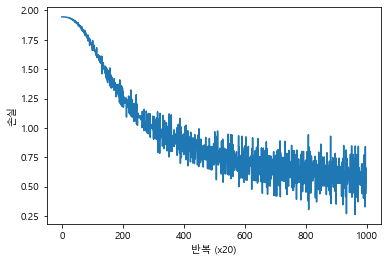

In [20]:
# 시각화
trainer.plot()

In [21]:
# W_in : 인스턴스 변수인 단어의 분산 표현
word_vecs = model.word_vec # (7,5)

for word_id, word in id_to_word.items():
    print('%10s : '%word, word_vecs[word_id])

       you :  [-1.1576275 -1.1275733 -1.1181736  1.0868896 -1.3008032]
       say :  [ 1.2234515   1.188574    1.2198206  -1.2201056   0.26780623]
   goodbye :  [-0.65437067 -0.85305285 -0.70957863  0.7816981  -0.7345267 ]
       and :  [ 0.96231675  1.003541    1.0038494  -0.9032868   1.8672729 ]
         i :  [-0.65883726 -0.8543849  -0.69965684  0.8007502  -0.74782807]
     hello :  [-1.2029454 -1.0971576 -1.107923   1.0922168 -1.294185 ]
         . :  [ 1.0833081   0.99575454  1.1252542  -1.138593   -1.760465  ]


In [22]:
id_to_word.items()

dict_items([(0, 'you'), (1, 'say'), (2, 'goodbye'), (3, 'and'), (4, 'i'), (5, 'hello'), (6, '.')])

### 예측 및 정확도 평가

In [23]:
# 예측
h = model.predict(contexts)
print(h)
print(h.shape) # (6,7)

[[8.16381383e-03 7.17599936e-01 3.48934794e-04 2.61877025e-01
  3.50165498e-04 3.47986685e-03 8.18025806e-03]
 [1.22762903e-02 8.18450402e-05 4.65651505e-01 2.57061949e-04
  4.64163787e-01 4.53145757e-02 1.22549349e-02]
 [1.99469721e-02 6.48607763e-01 1.66502890e-03 2.99664164e-01
  1.66934340e-03 8.50944163e-03 1.99372868e-02]
 [1.22762903e-02 8.18450402e-05 4.65651505e-01 2.57061949e-04
  4.64163787e-01 4.53145757e-02 1.22549349e-02]
 [8.08017516e-03 7.18839469e-01 3.40636370e-04 2.60886143e-01
  3.42119262e-04 3.41508382e-03 8.09637373e-03]
 [2.10896670e-03 2.35578558e-04 4.49088662e-02 4.23772507e-04
  4.49647540e-02 9.05180506e-01 2.17755640e-03]]
(6, 7)


In [24]:
preds = np.argmax(h,1)
t = np.argmax(target,1)
print('target:',t)
print('predict:',preds)

target: [1 2 3 4 1 5]
predict: [1 2 1 2 1 5]


In [25]:
# 정확도
accuracy = np.sum(np.equal(preds,t))/len(t)
print('정확도 :', np.round(accuracy,4))

정확도 : 0.6667
